# Advanced Lane finding

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


## Compute the camera calibration matrix and distortion coefficients from chessboard images 

In the next cells the following is done:
* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.


In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.image as mpimg
import Line
import os
import MyTools

%matplotlib qt
%matplotlib inline

In [2]:
def GetImageAndObjectPoints(imgPaths, doPlots=False): 
    # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
    objp = np.zeros((6*9,3), np.float32)
    objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

    # Arrays to store object points and image points from all the images.
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.

    # Step through the list and search for chessboard corners
    for fname in imgPaths:
        img = cv2.imread(fname)
        gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

        # Find the chessboard corners
        ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

        # If found, add object points, image points
        if ret == True:
            objpoints.append(objp)
            imgpoints.append(corners)
            
            if doPlots == True:
                # Draw and display the corners
                img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
                cv2.imshow('img',img)
                cv2.waitKey(500)

    if doPlots == True:
        cv2.destroyAllWindows()
    
    return imgpoints, objpoints

In [3]:
def cal_undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    ret, mtx, dist, x_, y_ = cv2.calibrateCamera(objpoints, imgpoints, img.shape[1:], None, None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist, mtx, dist


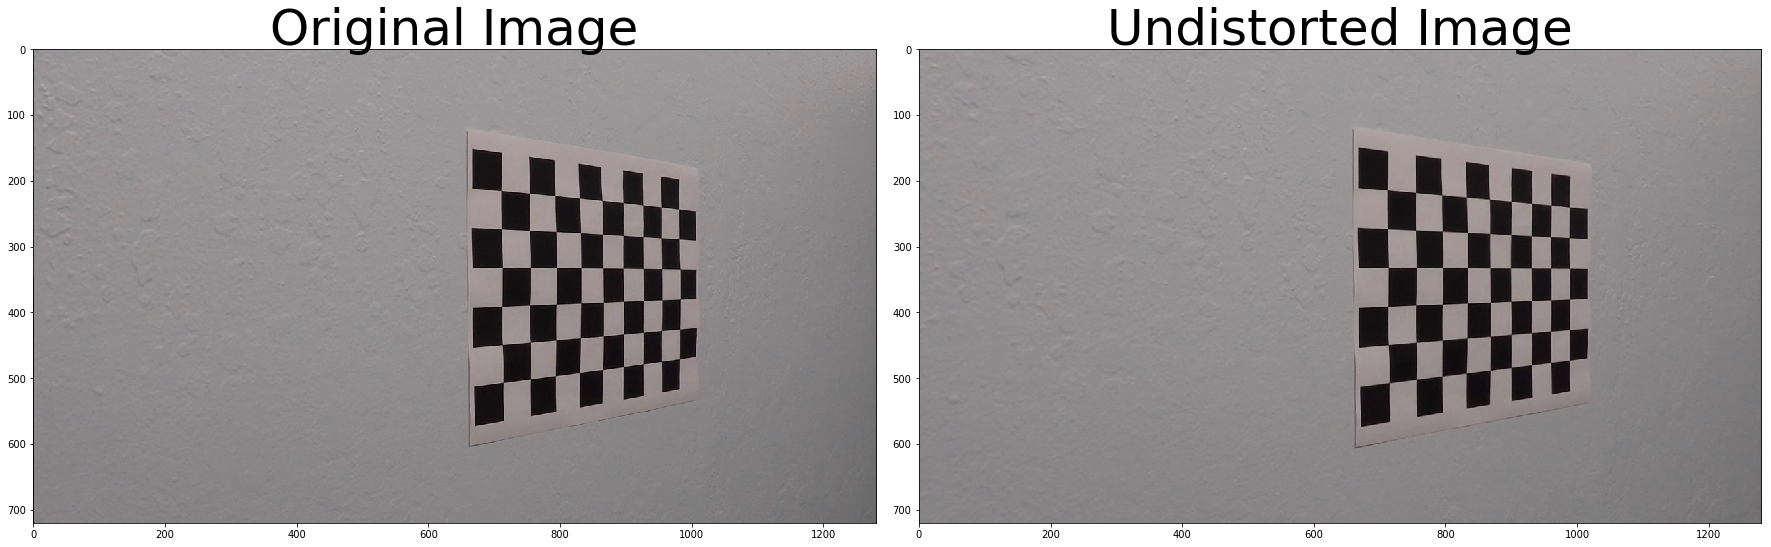

In [4]:
# ImgSavePath
imgSavePath = './output_images/'
# Make a list of calibration images
images = glob.glob('./camera_cal/calibration*.jpg')    

imgpoints, objpoints = GetImageAndObjectPoints(images, doPlots=False) 

# Use the objpoints and imgpoints found to Calibrate the camera and show result in an example image
img = cv2.imread(images[4])
img_undist, mtx, dist = cal_undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_undist)
ax2.set_title('Undistorted Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Use color and gradient transforms to obtain a binary image
In the following, I use the following techniques to obtain a good binary image of the road:
* Color transform to HSV, using the S channel (best result)
* Then I run a canny transform to get a good binary image
* Merge the transformed images to a best candidate

In [5]:
# Borrowed from the project-1
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

In [6]:
# Load Test images and undistort
testImages = glob.glob('./test_images/test*.jpg')
testImage = './test_images/test2.jpg' #testImages[0]
print('Image being used: ' + testImage)
img = cv2.imread(testImage)
img_undist = cv2.undistort(img, mtx, dist, None, mtx)

Image being used: ./test_images/test2.jpg


In [7]:
def CannyDetect(img):
    # Use blurring and canny transform to obtain a trhesholding image
    low_threshold  = 120
    high_threshold = 200
    # Gausian filter image for removing noise edges
    img_canny = cv2.GaussianBlur(img, (7, 7), 0)
    # Canny edge detection
    img_canny = cv2.Canny(img_canny, low_threshold, high_threshold)
    
    return img_canny

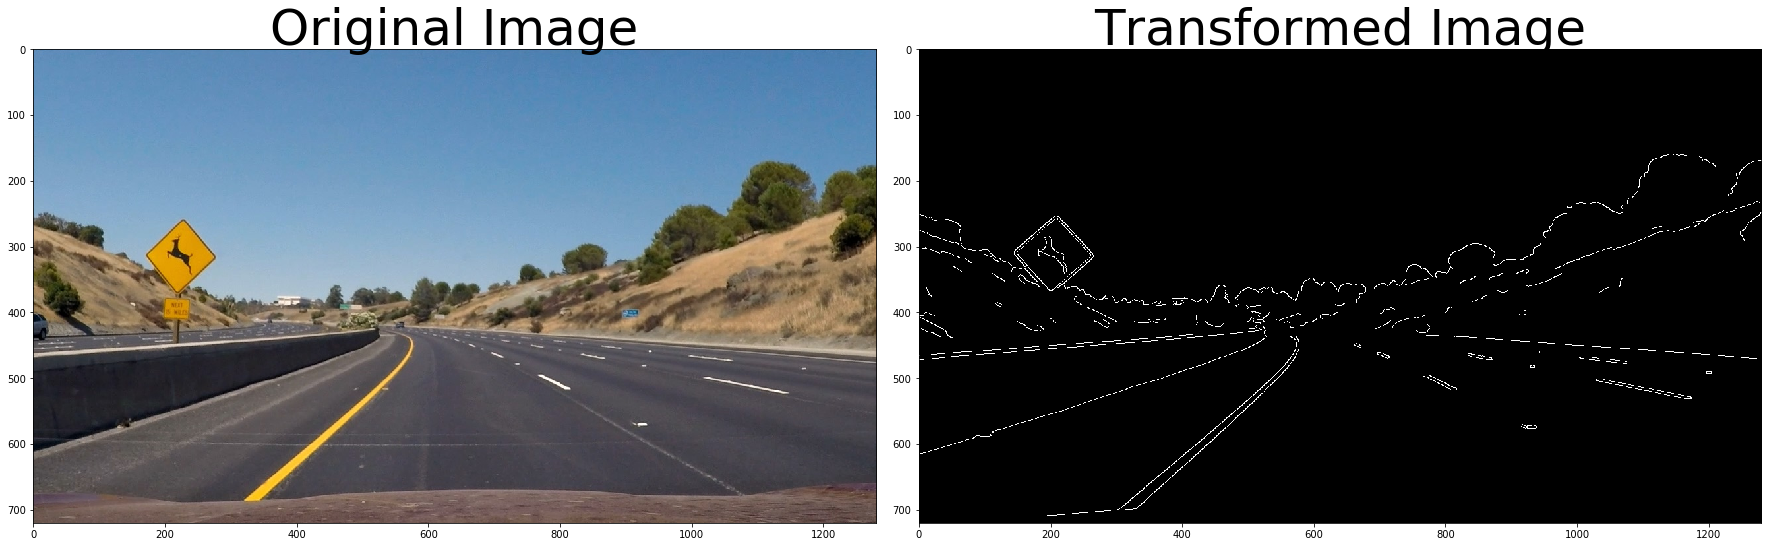

In [8]:
img_canny = CannyDetect(img_undist)
# Plot results
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(img_canny,'gray')
ax2.set_title('Transformed Image', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [9]:
def ColorThreshold(img):
    # Use Color transform to obtain a threshold image
    Col_Thres = 200
    img_hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
    h = img_hls[:,:,0]
    l = img_hls[:,:,1]
    s = img_hls[:,:,2]
    h_channel = np.zeros_like(h)
    l_channel = np.zeros_like(h)
    s_channel = np.zeros_like(h)
    h_channel[h > Col_Thres] = 255
    l_channel[l > Col_Thres] = 255
    s_channel[s > Col_Thres] = 255
    
    return h_channel, l_channel, s_channel

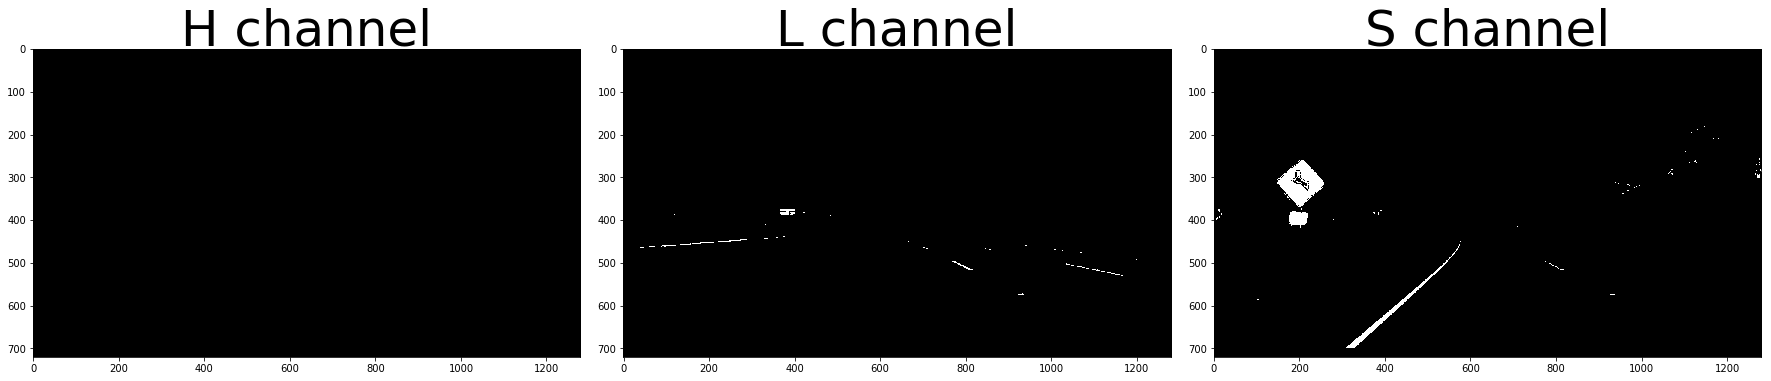

In [10]:
h_channel, l_channel, s_channel = ColorThreshold(img_undist)

# Plot results
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
f.tight_layout()
ax1.imshow(h_channel,'gray')
ax1.set_title('H channel', fontsize=50)
ax2.imshow(l_channel,'gray')
ax2.set_title('L channel', fontsize=50)
ax3.imshow(s_channel,'gray')
ax3.set_title('S channel', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

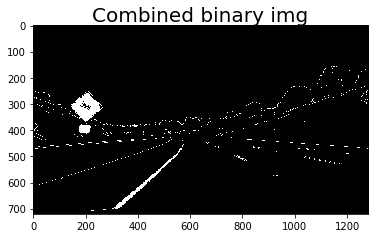

In [27]:
def CombineBinaryImages(img1, img2):
    # Combine images
    img_binary = np.zeros_like(img1)
    img_binary[img1.nonzero()] = 255
    img_binary[img2.nonzero()] = 255
    

In [ ]:
img_binary = CombineBinaryImages(s_channel, img_canny)

plt.imshow(img_binary,'gray')
plt.title('Combined binary img', fontsize=20)

## Apply a perspective transform to rectify binary image ("birds-eye view")

* Using a straight road image, find the perspective transform lines (or rectangle points) that can be used to transform images with
* Apply perspective transform using the points find, and draw a rectangle on the image road, and transform the road image back



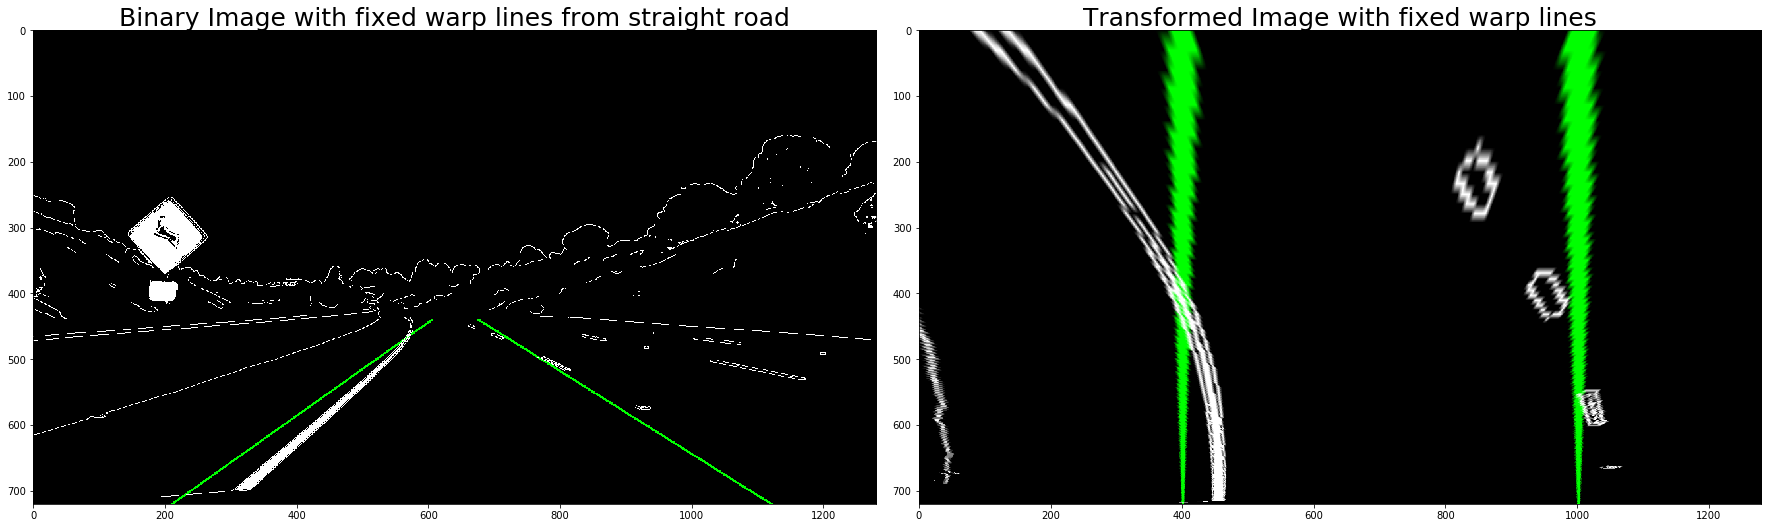

In [26]:
# Define some source points for perspective transform
dimY, dimX = img_binary.shape
src = np.float32([(210, dimY),(605, 440),(675, 440),(1120, dimY)])
# destination points
dst = np.float32([(400, dimY),(400, 0),(1000, 0),(1000, dimY)])

# Create an image to draw the lines on
warp_lines = np.zeros_like(img_binary).astype(np.uint8)
warp_lines = np.dstack((warp_lines, warp_lines, warp_lines))
# Draw the lane onto the warped blank image
cv2.line(warp_lines, (src[0,0],src[0,1]), (src[1,0],src[1,1]),(0,255, 0),2)
cv2.line(warp_lines, (src[2,0],src[2,1]), (src[3,0],src[3,1]),(0,255, 0),2)

# Add Warp lines and binary image together as color image
img_binary_col = np.dstack((img_binary,img_binary,img_binary)) + warp_lines

# Given src and dst points, calculate the perspective transform matrix
M = cv2.getPerspectiveTransform(src, dst)
# Warp the image using OpenCV warpPerspective()
img_warped_bin_col = cv2.warpPerspective(img_binary_col, M, (dimX, dimY))
img_warped_bin = cv2.warpPerspective(img_binary, M, (dimX, dimY))

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_BinImgWLines.jpg', imgSavePath, img_binary_col)
MyTools.MyImageWrite(name + '_BinImgBirdsEye.jpg', imgSavePath, img_warped_bin_col)

# Plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img_binary_col)
ax1.set_title('Binary Image with fixed warp lines from straight road', fontsize=25)
ax2.imshow(img_warped_bin_col)
ax2.set_title('Transformed Image with fixed warp lines', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

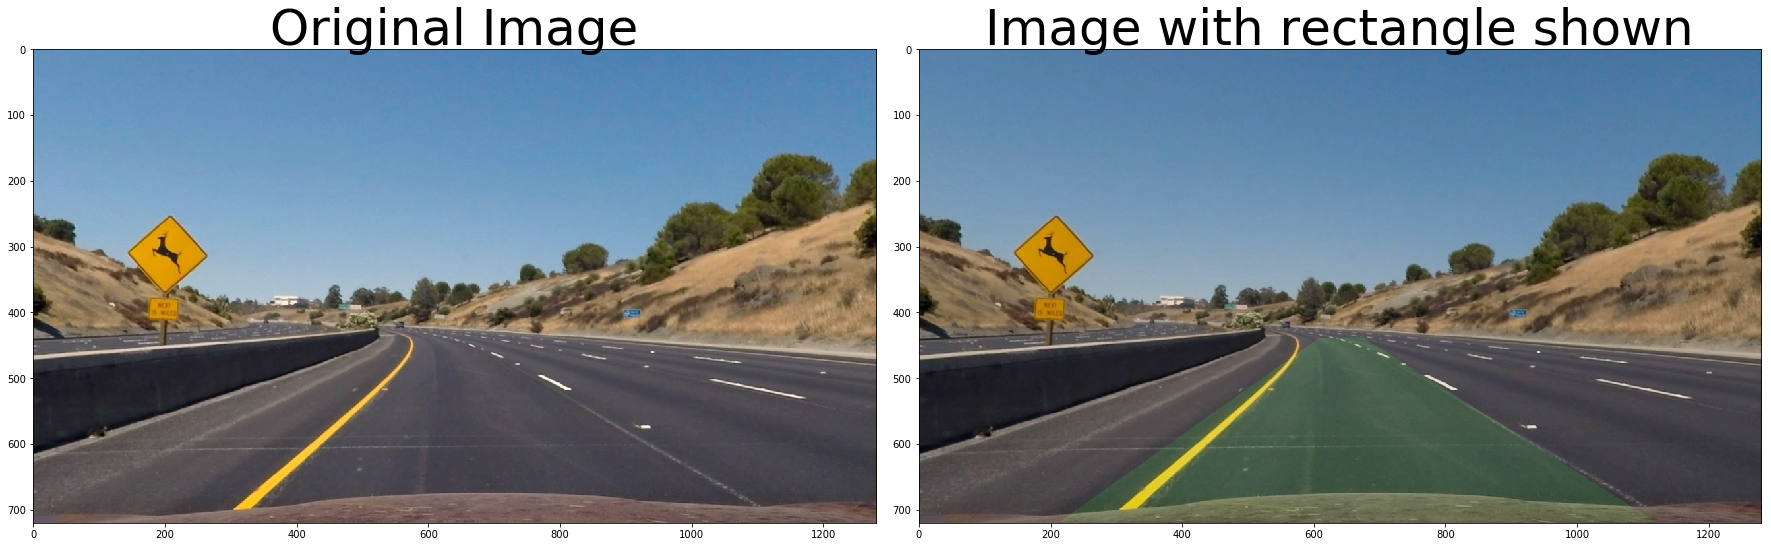

In [13]:
# Transform original image to birds eye, and apply a green rectangle and inverse transform image back to 
# drivers view

# Create rectangle image in birds eye view
img_rect = np.zeros_like(img_undist)
cv2.rectangle(img_rect, (dst[0,0],dst[0,1]), (dst[2,0],dst[2,1]), (0,255, 0),-1)
# Warp the rectangle using OpenCV warpPerspective() with inverse(M) 
img_rect_trans = cv2.warpPerspective(img_rect, np.linalg.inv(M), (dimX, dimY))

img_with_rect = cv2.addWeighted(img_undist, 0.9, img_rect_trans, 0.1, 0.0)

# Save images
name = MyTools.GetFileNameFromFilePath(testImage)
MyTools.MyImageWrite(name + '_ImageWRectangle.jpg', imgSavePath, img_with_rect)

# plot images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(cv2.cvtColor(img_undist, cv2.COLOR_BGR2RGB))
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(cv2.cvtColor(img_with_rect, cv2.COLOR_BGR2RGB))
ax2.set_title('Image with rectangle shown', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)


## Calculate line curvature from lane pixels
Using the Line() class with the binary and birds eye transformed image the following is done:
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.

Left and right line search x-val start 400 and 1028


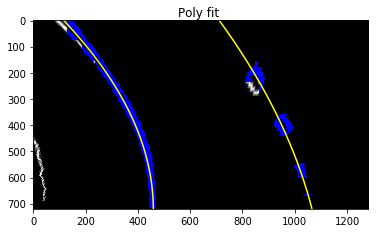

In [14]:
# get left and right lane Line objects:
LeftLane = Line.Line()
RightLane = Line.Line()

# Get an estimate on the left and right base x values
left_x, right_x = MyTools.FindLeftAndRightLaneXbaseFromHist(img_warped_bin)
left_x = 400
# Find lane pixels
print('Left and right line search x-val start {} and {}'.format(left_x,right_x))
LeftLane.find_lane_pixels(img_warped_bin, left_x)
LeftLane.fit_polynomial_from_idx()
RightLane.find_lane_pixels(img_warped_bin, right_x)
RightLane.fit_polynomial_from_idx()
img_plot = LeftLane.PlotPolynomialFit(img_warped_bin)
img_plot = RightLane.PlotPolynomialFit(img_plot)

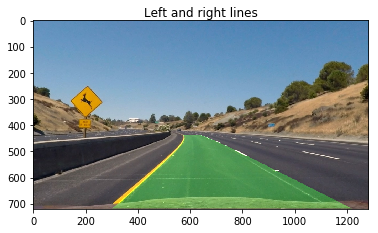

In [28]:
# Get image with green poly curve
img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped_bin, LeftLane.best_fit, RightLane.best_fit)

# Plot image ontop of binary warped image
MyTools.MergeAndPlotBGRImages(cv2.cvtColor(img_warped_bin, cv2.COLOR_GRAY2BGR), img_polyfit, 'Left and right lines')







In [ ]:
# Warp green poly curve image to drivers view
img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))

# plot warped poly curve image ontop of road image
MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')

In [29]:
# get left and right lane Line objects:
LeftLane = Line.Line()
RightLane = Line.Line()
    
def LanePipeline(img, M):
    dimY, dimX = img.shape[:2]
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)    
    img_canny  = CannyDetect(img_undist)
    h_channel, l_channel, s_channel = ColorThreshold(img_undist)
    img_binary = CombineBinaryImages(img_canny, s_channel)
    img_warped = cv2.warpPerspective(img_binary, M, (dimX, dimY))
    
    # Get an estimate on the left and right base x values
    left_x, right_x = MyTools.FindLeftAndRightLaneXbaseFromHist(img_warped)
    img_polyfit = MyTools.BirdsEyeLaneFromLeftAndRightPolynomials(img_warped, LeftLane.best_fit, RightLane.best_fit)
    img_polyfit_warped = cv2.warpPerspective(img_polyfit, np.linalg.inv(M), (dimX, dimY))
    MyTools.MergeAndPlotBGRImages(img_undist, img_polyfit_warped, 'Left and right lines')

In [ ]:
LeftLane.allx[-3:]
#np.mean(LeftLane.allx)
left_x